# Word2Vecを用いるセンチメント分析

In [1]:
import pandas as pd
import numpy as np
import torch
#device = torch.device('mps') # macbook
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## データ準備

### CSVファイルを読み込む

In [2]:
df= pd.read_csv('./Data/twitter_training.csv',names=['index','brand','sentiment','text'])
df.head()

FileNotFoundError: [Errno 2] No such file or directory: './Data/twitter_training.csv'

In [20]:
df["sentiment"].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: sentiment, dtype: int64

In [21]:
df["label"]=df["sentiment"].replace({"Positive":2,"Negative":0,"Neutral":1,"Irrelevant":np.nan})

In [22]:
df=df[['text','label']]
df=df.dropna()

### トレーニング、バリデーション、テストデータに分割

In [23]:
from sklearn.model_selection import train_test_split
# Split data (70% train, 15% validation, 15% test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

### テキストデータの前処理

- テキストを小文字に変換
- 句読点を削除
- トークン化

In [24]:
import re
import nltk
from nltk.tokenize import word_tokenize

# Download NLTK data (if not already done)
nltk.download('punkt')

# Function for preprocessing text
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    return tokens

[nltk_data] Downloading package punkt to /Users/ryozawau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
# Apply preprocessing
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
val_df['processed_text'] = val_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

### 単語分散表現によって特徴量の作成

In [26]:
import gensim.downloader
word2vec = gensim.downloader.load('word2vec-google-news-300')

In [27]:
def tokens_to_embedding(tokens, model, embedding_size=300):
    embeddings = [model[word] for word in tokens if word in model]
    if len(embeddings) == 0:
        return np.zeros(embedding_size)
    else:
        return np.mean(embeddings, axis=0)

In [28]:
train_df['embeddings'] = train_df['processed_text'].apply(lambda x: tokens_to_embedding(x, word2vec))
val_df['embeddings'] = val_df['processed_text'].apply(lambda x: tokens_to_embedding(x, word2vec))
test_df['embeddings'] = test_df['processed_text'].apply(lambda x: tokens_to_embedding(x, word2vec))

### 学習用データセットの作成

In [29]:
from torch.utils.data import DataLoader, TensorDataset

def create_dataset(df):
    features = torch.tensor(df['embeddings'].tolist(),dtype=torch.float32).to(device)
    labels = torch.tensor(df['label'].values, dtype=torch.long).to(device)
    return TensorDataset(features, labels)

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)
test_dataset = create_dataset(test_df)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### モデルの作成

In [46]:
import torch.nn as nn
import torch.optim as optim

# Define a simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model, Loss, and Optimizer
embedding_size = 300
model = SimpleNN(input_size=embedding_size, hidden_size=100, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 学習の実行


In [48]:
from sklearn.metrics import accuracy_score, f1_score
#from torch.utils.tensorboard import SummaryWriter
# Initialize the SummaryWriter
#writer = SummaryWriter('runs/sentiment')

num_epochs = 200
best_f1_score = 0.0
# Training loop
# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # Log training loss
    #writer.add_scalar('Loss/train', train_loss/len(train_loader), epoch)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.numpy())
            val_labels.extend(labels.numpy())
    # Log validation loss
    #writer.add_scalar('Loss/val', val_loss/len(val_loader), epoch)
    # Calculate accuracy and F1-score
    accuracy = accuracy_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds, average='weighted')
    # Log accuracy and F1-score
    #writer.add_scalar('Accuracy/val', accuracy, epoch)
    #writer.add_scalar('F1_Score/val', f1, epoch)

    print(f'Epoch {epoch+1}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')
    if f1 > best_f1_score:
        best_f1_score = f1
        # Save the model
        torch.save(model.state_dict(), './Model/best_model.pth')
        print(f"New best model saved at Epoch {epoch+1} with F1 Score: {f1:.4f}")

Epoch 1, Accuracy: 0.6624, F1 Score: 0.6575
New best model saved at Epoch 1 with F1 Score: 0.6575
Epoch 2, Accuracy: 0.6721, F1 Score: 0.6658
New best model saved at Epoch 2 with F1 Score: 0.6658
Epoch 3, Accuracy: 0.6843, F1 Score: 0.6820
New best model saved at Epoch 3 with F1 Score: 0.6820
Epoch 4, Accuracy: 0.6883, F1 Score: 0.6857
New best model saved at Epoch 4 with F1 Score: 0.6857
Epoch 5, Accuracy: 0.6932, F1 Score: 0.6916
New best model saved at Epoch 5 with F1 Score: 0.6916
Epoch 6, Accuracy: 0.6975, F1 Score: 0.6950
New best model saved at Epoch 6 with F1 Score: 0.6950
Epoch 7, Accuracy: 0.7042, F1 Score: 0.6986
New best model saved at Epoch 7 with F1 Score: 0.6986
Epoch 8, Accuracy: 0.7129, F1 Score: 0.7099
New best model saved at Epoch 8 with F1 Score: 0.7099
Epoch 9, Accuracy: 0.7182, F1 Score: 0.7147
New best model saved at Epoch 9 with F1 Score: 0.7147
Epoch 10, Accuracy: 0.7301, F1 Score: 0.7296
New best model saved at Epoch 10 with F1 Score: 0.7296
Epoch 11, Accuracy

## テストデータでモデルを検証する

In [49]:
#model.load_state_dict(torch.load('./Model/best_model.pth'))
# Testing loop
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.numpy())
        test_labels.extend(labels.numpy())

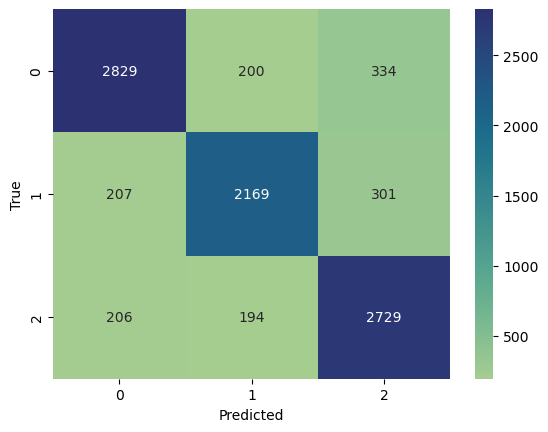

In [50]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()